In [21]:
# ==========================================
# 1️⃣ Imports & Data Loading
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

base = "/content/drive/MyDrive/Data_Upside/"

accounts = pd.read_csv(base + "ravenstack_accounts.csv", parse_dates=["signup_date"])
support = pd.read_csv(base + "ravenstack_support_tickets.csv", parse_dates=["submitted_at","closed_at"])
subscriptions = pd.read_csv(base + "ravenstack_subscriptions.csv", parse_dates=["start_date","end_date"])
usage = pd.read_csv(base + "ravenstack_feature_usage.csv", parse_dates=["usage_date"])
churn = pd.read_csv(base + "ravenstack_churn_events.csv", parse_dates=["churn_date"])

In [22]:
# normalize boolean-like columns (convert "TRUE"/"FALSE" strings to booleans)
bool_cols_accounts = ['is_trial', 'churn_flag']
for c in bool_cols_accounts:
    if c in accounts.columns:
        accounts[c] = accounts[c].astype(str).str.upper().map({'TRUE': True, 'FALSE': False, 'TRUE ': True}).fillna(accounts[c])

        if accounts[c].dtype == object:
            accounts[c] = accounts[c].replace({'TRUE':'True','FALSE':'False'}).map({'True':True,'False':False}).fillna(accounts[c])

# subscriptions boolean-like
for c in ['is_trial','upgrade_flag','downgrade_flag','churn_flag','auto_renew_flag']:
    if c in subscriptions.columns:
        subscriptions[c] = subscriptions[c].astype(str).str.upper().map({'TRUE': True, 'FALSE': False}).where(lambda s: s.notna(), None)

# support: make satisfaction_score numeric and mark blanks as NaN
if 'satisfaction_score' in support.columns:
    support['satisfaction_score'] = pd.to_numeric(support['satisfaction_score'], errors='coerce')

# feature usage: ensure is_beta_feature boolean
if 'is_beta_feature' in usage.columns:
    usage['is_beta_feature'] = usage['is_beta_feature'].astype(str).str.upper().map({'TRUE': True, 'FALSE': False})
    # fallback: if already bool, keep it
    usage['is_beta_feature'] = usage['is_beta_feature'].fillna(False)

# churn events: standardize churn reason column name to 'churn_reason'
if 'reason_code' in churn.columns and 'churn_reason' not in churn.columns:
    churn = churn.rename(columns={'reason_code':'churn_reason'})

# subscriptions: parse numeric columns explicitly
for col in ['mrr_amount','arr_amount','seats']:
    if col in subscriptions.columns:
        subscriptions[col] = pd.to_numeric(subscriptions[col], errors='coerce').fillna(0)

# support: closed_at may be blank or parsed as string; ensure datetime dtype
for c in ['submitted_at','closed_at']:
    if c in support.columns:
        support[c] = pd.to_datetime(support[c], errors='coerce')

# subscriptions: ensure start_date/end_date are datetimes
for c in ['start_date','end_date']:
    if c in subscriptions.columns:
        subscriptions[c] = pd.to_datetime(subscriptions[c], errors='coerce')

# accounts: ensure signup_date is datetime
if 'signup_date' in accounts.columns:
    accounts['signup_date'] = pd.to_datetime(accounts['signup_date'], errors='coerce')

# --- Diagnostics: print quick checks ---
print("Sample booleans (accounts.is_trial, churn_flag):")
print(accounts[['account_id'] + [c for c in bool_cols_accounts if c in accounts.columns]].head())

# orphan usage check
orphan_sub_ids = set(usage['subscription_id'].dropna().unique()) - set(subscriptions['subscription_id'].dropna().unique())
print(f"Orphan subscription_ids in usage (count): {len(orphan_sub_ids)}")
if len(orphan_sub_ids) > 0:
    print("Example orphan subscription_ids:", list(orphan_sub_ids)[:5])

# support satisfaction stats
if 'satisfaction_score' in support.columns:
    print("Support satisfaction_score non-null count:", support['satisfaction_score'].notna().sum())
    print("Support satisfaction_score sample values:", support['satisfaction_score'].dropna().unique()[:10])

# churn reason rename check
print("Churn columns:", churn.columns.tolist())

Sample booleans (accounts.is_trial, churn_flag):
  account_id  is_trial  churn_flag
0   A-2e4581     False       False
1   A-43a9e3     False        True
2   A-0a282f     False       False
3   A-1f0ac7      True       False
4   A-ce550d     False        True
Orphan subscription_ids in usage (count): 0
Support satisfaction_score non-null count: 1175
Support satisfaction_score sample values: [4. 5. 3.]
Churn columns: ['churn_event_id', 'account_id', 'churn_date', 'churn_reason', 'refund_amount_usd', 'preceding_upgrade_flag', 'preceding_downgrade_flag', 'is_reactivation', 'feedback_text']


In [23]:
# ==========================================
# 2️⃣ Data Cleaning
# ==========================================
accounts = accounts.drop_duplicates(subset=['account_id'], keep='first')
assert accounts['account_id'].is_unique

subscriptions = subscriptions.drop_duplicates(subset=['subscription_id'], keep='first')
assert subscriptions['subscription_id'].is_unique

usage = usage.groupby('usage_id').agg({
    'subscription_id':'first',
    'usage_date':'first',
    'feature_name':'first',
    'usage_count':'sum',
    'usage_duration_secs':'sum',
    'error_count':'sum',
    'is_beta_feature':'first'
}).reset_index()
assert usage['usage_id'].is_unique

support = support.groupby('ticket_id').agg({
    'account_id':'first',
    'submitted_at':'first',
    'closed_at':'first',
    'resolution_time_hours':'sum',
    'priority':'first',
    'first_response_time_minutes':'sum',
    'satisfaction_score':'first',
    'escalation_flag':'first'
}).reset_index()
assert support['ticket_id'].is_unique

churn = churn.drop_duplicates(subset=['churn_event_id'], keep='first')
assert churn['churn_event_id'].is_unique

print("✅ All tables cleaned and IDs are unique")

✅ All tables cleaned and IDs are unique


In [24]:
# ==========================================
# 3️⃣ Feature Engineering
# ==========================================
cutoff_date = pd.to_datetime("2024-12-31")

# --- Account-level features
features = accounts[['account_id','plan_tier','seats','is_trial','churn_flag']].copy()
features['account_age_days'] = (cutoff_date - accounts['signup_date']).dt.days

# --- Subscription-level features
latest_sub = subscriptions.sort_values('start_date').groupby('account_id').last().reset_index()
features = features.merge(latest_sub[['account_id','mrr_amount']], on='account_id', how='left')

# --- Feature usage features
usage_last_30 = usage[usage['usage_date'] > (cutoff_date - pd.Timedelta(days=30))].copy()
usage_last_30['beta_usage'] = np.where(usage_last_30['is_beta_feature'],
                                       usage_last_30['usage_count'], 0)

usage_agg = usage_last_30.groupby('subscription_id').agg(
    total_usage=('usage_count','sum'),
    beta_usage=('beta_usage','sum'),
    last_usage_date=('usage_date','max')
).reset_index()

usage_agg = usage_agg.merge(subscriptions[['subscription_id','account_id']], on='subscription_id')

usage_feat = usage_agg.groupby('account_id').agg(
    total_usage_last_30=('total_usage','sum'),
    beta_usage_last_30=('beta_usage','sum'),
    last_usage_date=('last_usage_date','max')
).reset_index()

features = features.merge(usage_feat, on='account_id', how='left')

features['days_since_last_usage'] = (cutoff_date - features['last_usage_date']).dt.days
features['days_since_last_usage'] = features['days_since_last_usage'].fillna(999)

# --- Support features
support_last_30 = support[support['submitted_at'] > (cutoff_date - pd.Timedelta(days=30))]
support_feat = support_last_30.groupby('account_id').agg(
    tickets_last_30=('ticket_id','count'),
    avg_resolution_time=('resolution_time_hours','mean'),
    last_satisfaction_score=('satisfaction_score','last')
).reset_index()

features = features.merge(support_feat, on='account_id', how='left')

features[['total_usage_last_30','beta_usage_last_30','days_since_last_usage',
          'tickets_last_30','avg_resolution_time','last_satisfaction_score']] = \
    features[['total_usage_last_30','beta_usage_last_30','days_since_last_usage',
              'tickets_last_30','avg_resolution_time','last_satisfaction_score']].fillna(0)

print("✅ Feature table created")
print(features.head())

✅ Feature table created
  account_id   plan_tier  seats  is_trial  churn_flag  account_age_days  \
0   A-2e4581       Basic      9     False       False                76   
1   A-43a9e3       Basic     18     False        True               502   
2   A-0a282f       Basic      1     False       False               126   
3   A-1f0ac7       Basic     24      True       False               492   
4   A-ce550d  Enterprise     35     False        True                65   

   mrr_amount  total_usage_last_30  beta_usage_last_30 last_usage_date  \
0         836                 13.0                 0.0      2024-12-10   
1         882                 12.0                12.0      2024-12-29   
2          98                 78.0                 0.0      2024-12-22   
3        1176                 28.0                 0.0      2024-12-11   
4       21691                 20.0                 0.0      2024-12-23   

   days_since_last_usage  tickets_last_30  avg_resolution_time  \
0             

Churn vs Non-Churn average feature values
   churn_flag   mrr_amount      seats  account_age_days  total_usage_last_30  \
0       False  2470.776923  20.933333        329.433333            20.310256   
1        True  2317.745455  19.236364        371.672727            22.881818   

   beta_usage_last_30  days_since_last_usage  tickets_last_30  \
0            1.728205             172.871795         0.179487   
1            2.218182             108.009091         0.163636   

   avg_resolution_time  last_satisfaction_score  
0             6.293590                 0.397436  
1             4.272727                 0.372727  


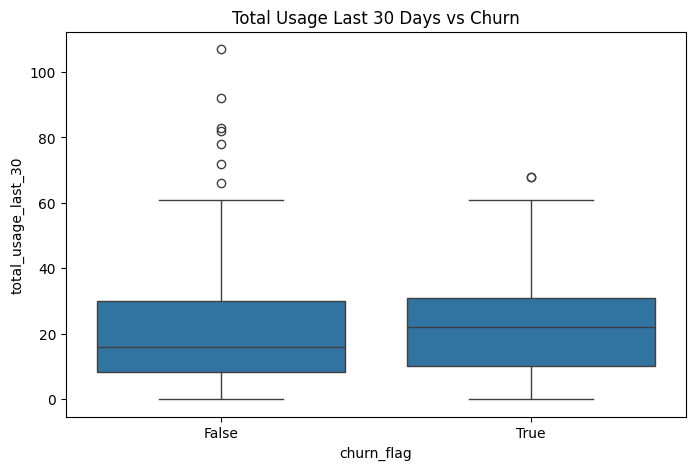

In [25]:
# ==========================================
# 4️⃣ EDA: Churn vs Non-Churn
# ==========================================
eda_cols = ['mrr_amount','seats','account_age_days','total_usage_last_30',
            'beta_usage_last_30','days_since_last_usage','tickets_last_30',
            'avg_resolution_time','last_satisfaction_score']

churn_summary = features.groupby('churn_flag')[eda_cols].mean().reset_index()
print("Churn vs Non-Churn average feature values")
print(churn_summary)

plt.figure(figsize=(8,5))
sns.boxplot(x='churn_flag', y='total_usage_last_30', data=features)
plt.title("Total Usage Last 30 Days vs Churn")
plt.show()

In [26]:
# ==========================================
# 5️⃣ Save features
# ==========================================
features.to_csv(base + "features_for_model.csv", index=False)
print("✅ Features saved to CSV")

✅ Features saved to CSV


ROC AUC Score: 0.584

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.54      0.67       123
           1       0.23      0.63      0.34        27

    accuracy                           0.56       150
   macro avg       0.55      0.59      0.51       150
weighted avg       0.76      0.56      0.61       150



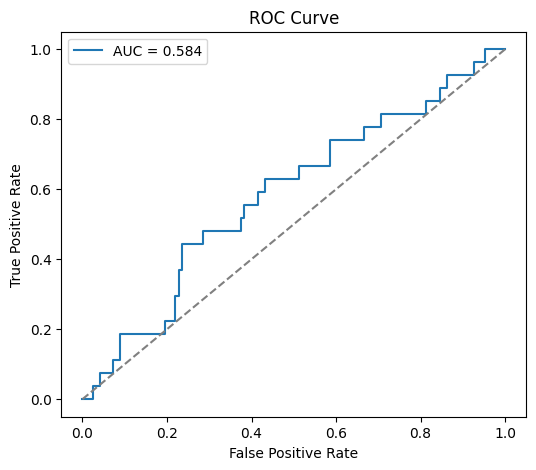

In [27]:
# ==========================================
# 6️⃣ Churn Prediction Model
# ==========================================
df = features.copy()

# --- Encode categorical
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
encoded = encoder.fit_transform(df[['plan_tier']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['plan_tier']))
df = pd.concat([df.drop(columns=['plan_tier']), encoded_df], axis=1)

# --- Features & Target
X = df.drop(columns=['account_id','churn_flag','last_usage_date'])
y = df['churn_flag'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_scaled, y_train)

y_pred_prob = model.predict_proba(X_test_scaled)[:,1]
y_pred = model.predict(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [28]:
importance = pd.DataFrame({
    'feature': X.columns,
    'coef': model.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)
print("Top features influencing churn:")
print(importance.head(10))

Top features influencing churn:
                   feature      coef
8      avg_resolution_time -0.295792
2         account_age_days  0.118223
3               mrr_amount -0.093327
4      total_usage_last_30  0.089932
0                    seats -0.087963
5       beta_usage_last_30  0.079872
1                 is_trial  0.075786
9  last_satisfaction_score  0.065933
7          tickets_last_30  0.059761
6    days_since_last_usage  0.022404


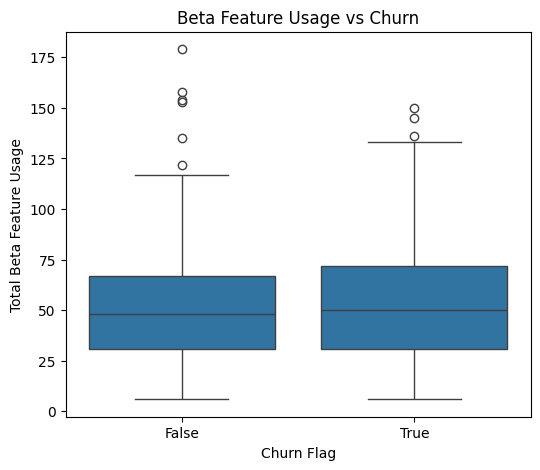

In [29]:
# ==========================================
# 7️⃣ Additional Analyses
# ==========================================
# --- Beta Feature Adoption
beta_usage = usage[usage['is_beta_feature']].groupby('subscription_id').agg(
    beta_usage_count=('usage_count','sum')
).reset_index()

beta_usage = beta_usage.merge(subscriptions[['subscription_id','account_id']], on='subscription_id')
beta_usage_account = beta_usage.groupby('account_id')['beta_usage_count'].sum().reset_index()
beta_usage_account = beta_usage_account.merge(accounts[['account_id','churn_flag']], on='account_id', how='left')

plt.figure(figsize=(6,5))
sns.boxplot(x='churn_flag', y='beta_usage_count', data=beta_usage_account)
plt.title("Beta Feature Usage vs Churn")
plt.xlabel("Churn Flag")
plt.ylabel("Total Beta Feature Usage")
plt.show()

/tmp/ipython-input-1276547275.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='referral_source', y='churn_rate', data=referral_summary, palette='coolwarm')


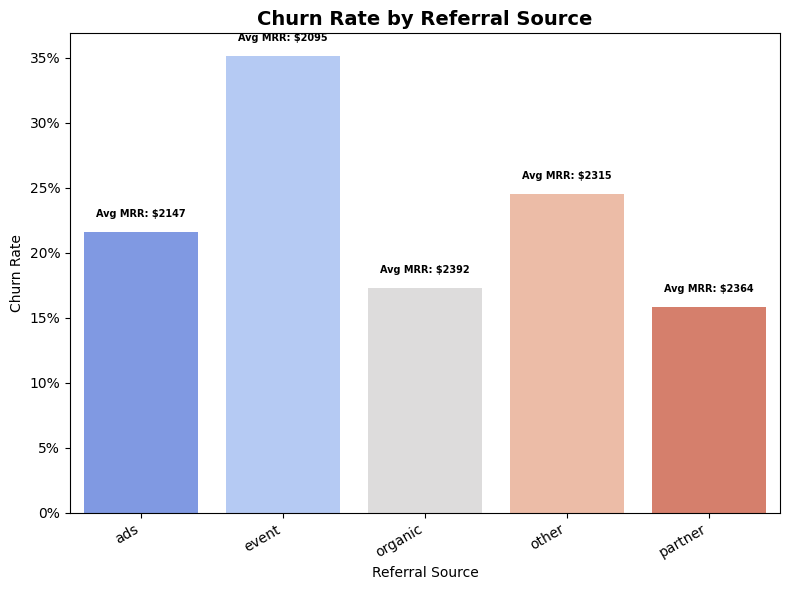

  referral_source  total_accounts  churned_accounts      avg_mrr  churn_rate
0             ads            1000               216  2146.619000    0.216000
1           event             917               322  2095.365322    0.351145
2         organic            1170               202  2392.057265    0.172650
3           other            1027               252  2315.217137    0.245375
4         partner             886               140  2363.705418    0.158014


In [30]:
# --- Churn Rate by Referral Source
referral_churn = accounts.merge(subscriptions[['account_id','mrr_amount']], on='account_id', how='left')

referral_summary = referral_churn.groupby('referral_source').agg(
    total_accounts=('account_id', 'count'),
    churned_accounts=('churn_flag', lambda x: (x == True).sum()),
    avg_mrr=('mrr_amount', 'mean')
).reset_index()

referral_summary['churn_rate'] = referral_summary['churned_accounts'] / referral_summary['total_accounts']

# Plot
plt.figure(figsize=(8,6))
ax = sns.barplot(x='referral_source', y='churn_rate', data=referral_summary, palette='coolwarm')

for p, avg_mrr in zip(ax.patches, referral_summary['avg_mrr']):
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height + 0.01,
        s=f"Avg MRR: ${avg_mrr:.0f}",
        ha='center',
        va='bottom',
        fontsize=7,
        fontweight='bold'
    )

ax.set_title("Churn Rate by Referral Source", fontsize=14, fontweight="bold")
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Referral Source")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

print(referral_summary)

/tmp/ipython-input-3964191593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='referral_source', y='mrr_amount', data=revenue_by_referral, palette='viridis')


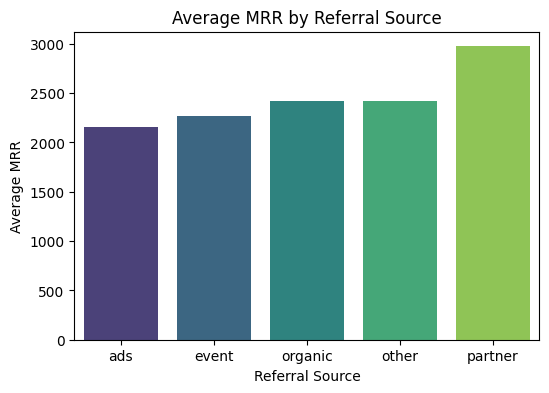

In [31]:
# --- Revenue Cohort by Referral Source
latest_sub = subscriptions.sort_values('start_date').groupby('account_id').last().reset_index()
revenue_cohort = latest_sub.merge(accounts[['account_id','referral_source']], on='account_id', how='left')
revenue_by_referral = revenue_cohort.groupby('referral_source')['mrr_amount'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='referral_source', y='mrr_amount', data=revenue_by_referral, palette='viridis')
plt.title("Average MRR by Referral Source")
plt.ylabel("Average MRR")
plt.xlabel("Referral Source")
plt.show()

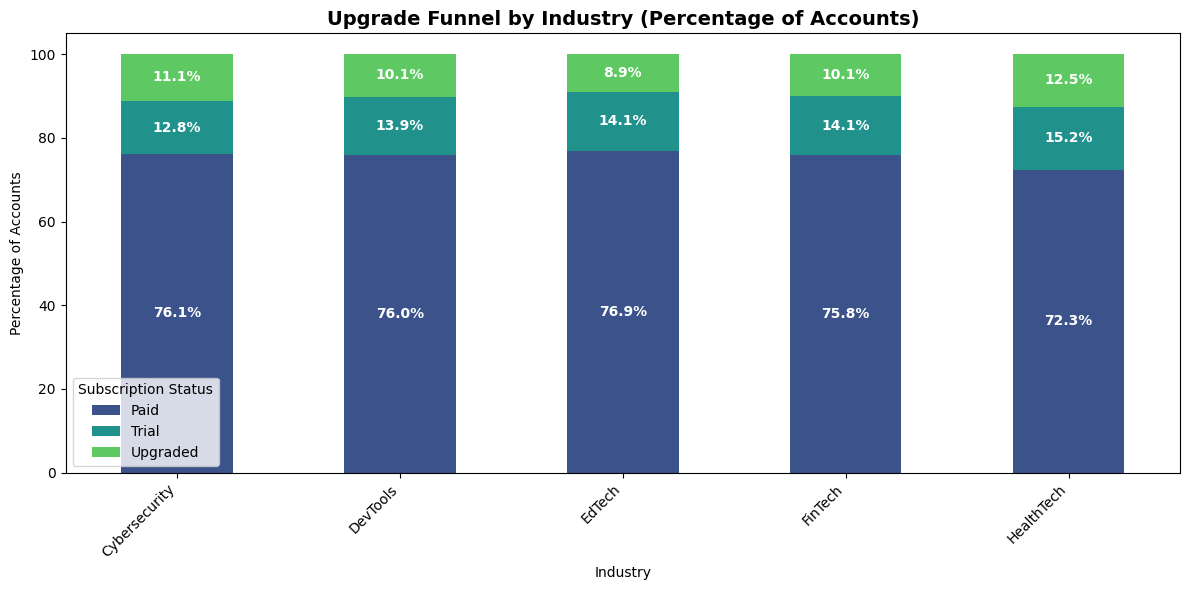

In [32]:
# --- Upgrade Funnel by Industry
funnel_pivot = funnel_counts.pivot(index='industry', columns='status', values='count').fillna(0)

# Convert counts to percentages per industry
funnel_percent = funnel_pivot.div(funnel_pivot.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(12,6))
colors = sns.color_palette("viridis", n_colors=funnel_percent.shape[1])
funnel_percent.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())

for idx, industry in enumerate(funnel_percent.index):
    cumulative = 0
    for status in funnel_percent.columns:
        pct = funnel_percent.loc[industry, status]
        if pct > 0:
            plt.text(idx, cumulative + pct/2, f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            cumulative += pct

plt.title("Upgrade Funnel by Industry (Percentage of Accounts)", fontsize=14, fontweight='bold')
plt.ylabel("Percentage of Accounts")
plt.xlabel("Industry")
plt.legend(title='Subscription Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

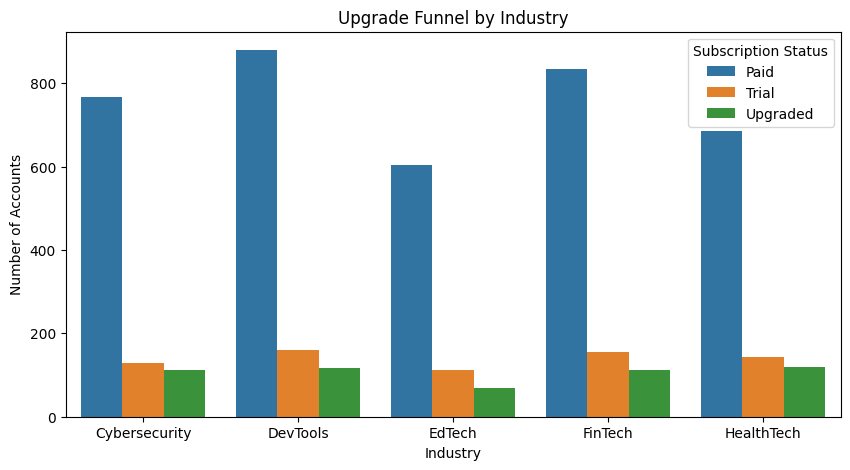

In [33]:
# --- Upgrade Funnel by Industry
conditions = [
    subscriptions['upgrade_flag'] == True,
    subscriptions['is_trial'] == True
]
choices = ['Upgraded', 'Trial']
subscriptions['status'] = np.select(conditions, choices, default='Paid')

funnel_data = subscriptions.merge(accounts[['account_id','industry']], on='account_id', how='left')
funnel_counts = funnel_data.groupby(['industry','status']).size().reset_index(name='count')

plt.figure(figsize=(10,5))
sns.barplot(x='industry', y='count', hue='status', data=funnel_counts)
plt.title("Upgrade Funnel by Industry")
plt.ylabel("Number of Accounts")
plt.xlabel("Industry")
plt.legend(title='Subscription Status')
plt.show()

/tmp/ipython-input-1300565996.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='plan_tier', y='churn_rate', data=churn_summary, palette='viridis')


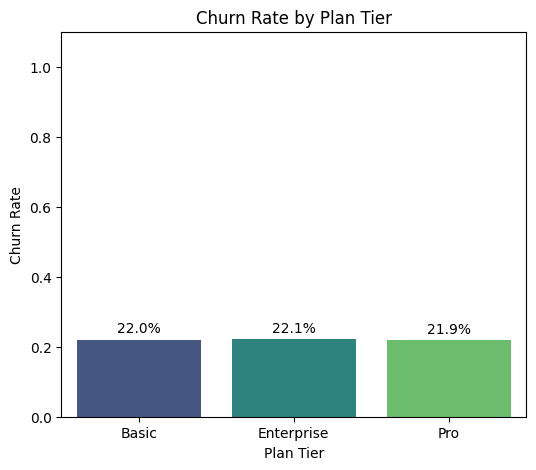

In [34]:
# Load features
features = pd.read_csv(base + "features_for_model.csv")

# Calculate churn rate per plan tier
churn_summary = features.groupby('plan_tier')['churn_flag'].mean().reset_index()
churn_summary.rename(columns={'churn_flag':'churn_rate'}, inplace=True)

plt.figure(figsize=(6,5))
ax = sns.barplot(x='plan_tier', y='churn_rate', data=churn_summary, palette='viridis')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.02,
        s=f"{height*100:.1f}%",
        ha='center'
    )

plt.ylabel("Churn Rate")
plt.xlabel("Plan Tier")
plt.title("Churn Rate by Plan Tier")
plt.ylim(0, 1.1)
plt.show()

/tmp/ipython-input-30130885.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='churn_reason', y='percentage',


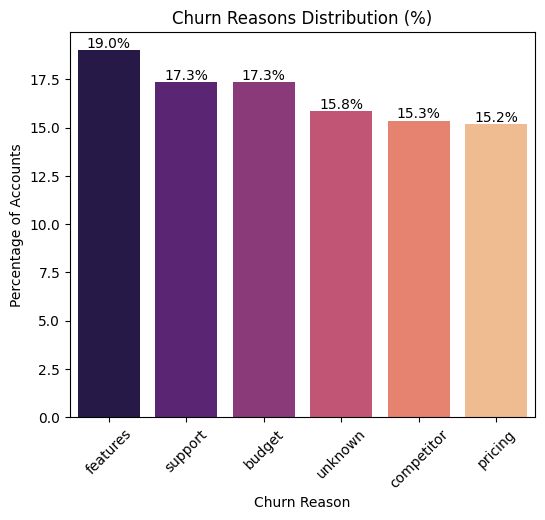

In [35]:
# Load churn events
churn_events = pd.read_csv(base + "ravenstack_churn_events.csv")

# Count churn reasons and calculate percentages
churn_reason_summary = churn_events['reason_code'].value_counts(normalize=True).reset_index()
churn_reason_summary.columns = ['churn_reason','percentage']
churn_reason_summary['percentage'] *= 100  # convert to %

plt.figure(figsize=(6,5))
ax = sns.barplot(x='churn_reason', y='percentage',
                 data=churn_reason_summary, palette='magma')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.ylabel("Percentage of Accounts")
plt.xlabel("Churn Reason")
plt.title("Churn Reasons Distribution (%)")
plt.xticks(rotation=45)
plt.show()